# Intro

It's the last time we meet in class for exercises! And to celebrate this mile-stone, I've put together an very nice little set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - That's it!


# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.



> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.



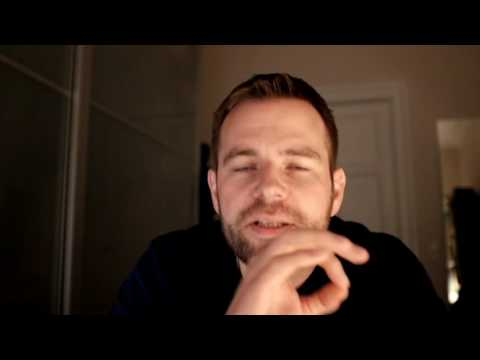

In [85]:
from IPython.display import YouTubeVideo
YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

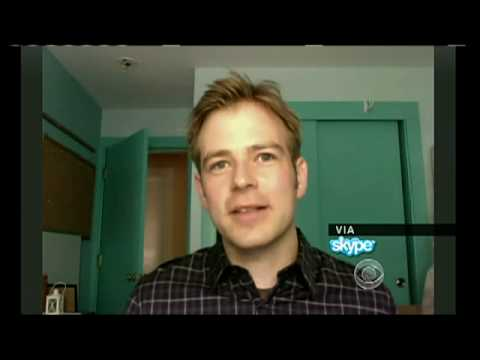

In [86]:
# There's also this one from 2010
YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


*Exercise*: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterage over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property.
> * Calculate the average sentiment across all the pages. Also calculate the median, variance, 25th percentile, 75th percentile.
> * Remember histograms? Create a histogram of all of the artists's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2). Add the mean, meadian, ect from above to your plot.
> * Who are the 10 artists with happiest and saddest pages?

<div class="alert alert-block alert-info">
As long as you get the plots right, it's OK to use LLM help here.
</div>

*Exercise*: Community sentiment distribution. 
  
> * Last week we calculated the stuctural communities of the graph. For this exercise, we use those communities (just the 10 largest ones). Specifically, you should calculate the average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected characters. 
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by comparing to the genres, checking out the word-clouds for each community, and reading the wiki-pages? 
> * Compare the sentiment of the happiest and saddest communities to the overall (entire network) distribution of sentiment that you calculated in the previous exercise. Are the communities very differenct from the average? Or do you find the sentiment to be quite similar across all of the communities?

<div class="alert alert-block alert-info">
As above, feel free to go nuts with help from an LLM with this exercise for the technical parts. But try to answer the questions about interpreting the results with your own human brain.
</div>

**Note**: Calculating sentiment takes a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

In [ ]:
import urllib
import requests
import os 
import json 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from nltk.tokenize import word_tokenize
from collections import defaultdict
import community.community_louvain as community

In [88]:
def calculate_sentiment(tokens, labmt_path='labMT.txt'):
    # Read the LabMT data into a dictionary
    word_sentiment = {}
    with open(labmt_path, 'r', encoding='utf-8') as file:
        for line in file:
            # Skip lines that are headers or irrelevant
            if 'happiness_average' in line or line.startswith('word'):
                continue
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                try:
                    word = parts[0].lower()
                    sentiment_score = float(parts[2])
                    word_sentiment[word] = sentiment_score
                except ValueError:
                    continue  # Skip lines that do not convert properly

    # Gather sentiment scores for the tokens
    scores = [word_sentiment[token.lower()] for token in tokens if token.lower() in word_sentiment]

    # Check if there are valid scores
    if scores:
        avg_score = np.mean(scores)
        median_score = np.median(scores)
        variance_score = np.var(scores)
        percentile_25 = np.percentile(scores, 25)
        percentile_75 = np.percentile(scores, 75)

        return {
            'average': avg_score,
            'median': median_score,
            'variance': variance_score,
            '25th_percentile': percentile_25,
            '75th_percentile': percentile_75
        }
    else:
        return None  # Return None if no valid words were found

# Example usage
tokens = ['happy', 'sad', 'joy', 'unknown']
statistics = calculate_sentiment(tokens)
if statistics:
    for key, value in statistics.items():
        print(f"{key.capitalize()}: {value}")
else:
    print("No valid sentiment scores found.")


Average: 5.72
Median: 6.1
Variance: 6.647000000000001
25th_percentile: 3.625
75th_percentile: 8.195


In [89]:
# acquire the singer names list
def wikiinfo(title):
    baseurl =  "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = urllib.parse.urlencode({'titles': title})
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikijson = json.loads(wikitext)
    return wikijson
wikijson = wikiinfo(title="List_of_country_music_performers")
#the content include the singer names
artist_content = wikijson['query']['pages']['328877']['revisions'][0]['*'] 
#extract the singer names
singer_names = re.findall(r'\*\[\[([^\|\(\]]+)', artist_content)
#remove the duplicate names and sort the names 
singer_names = sorted(set(singer_names)) 
# Extract [[...]] from the content and clean by removing parentheses and text after '|'
def get_connected_names(content):
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    connected_names = [re.sub(r'\(.*?\)|\|.*', '', match).strip() for match in matches]
    return connected_names

# fliter the connected names that are in the singer_names list
def filter_connected_names(connected_names, singer_names):
    filtered_names = [name for name in connected_names if name in singer_names]
    return filtered_names

# Count the number of words in the content
def count_words(content):
    return len(re.findall(r'\b\w+\b', content))

def get_connected_map(folder_path, singer_names):
    # Create a undirected graph
    G = nx.Graph()
    folder_path = os.path.abspath(folder_path)
    
    # Iterate through all the .txt files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            if os.path.exists(file_path):
                
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                
                # Use the file name as the node
                filename_m = os.path.splitext(filename)[0]
            
                # Check if the content is empty and set content_length accordingly
                content_length = count_words(content=content) if content.strip() else 0
                
                # Add the node with the content_length as an attribute
                G.add_node(filename_m, content_length=content_length)
                
                # Get and filter the connected names
                connected_names = get_connected_names(content)
                filtered_names = filter_connected_names(connected_names, singer_names)
                
                # Add edges for each filtered name
                for name in filtered_names:
                    G.add_edge(filename_m, name)
            else:
                print(f"File not found: {file_path}")

    return G


folder_path = 'wiki_pages'  
G = get_connected_map(folder_path, singer_names)
G.remove_edges_from(nx.selfloop_edges(G))  # remove self-loop edges
# the bascial information of the graph
print(f"Graph has {G.number_of_nodes()} \n nodes and {G.number_of_edges()} edges.")

Graph has 2102 
 nodes and 12997 edges.


In [90]:
node_sentiment = {}
for node in list(G.nodes()):
    file_path = os.path.join(folder_path, node + ".txt")  # Add .txt extension
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            tokens = word_tokenize(content)
            node_sentiment[node] = calculate_sentiment(tokens)
nx.set_node_attributes(G, node_sentiment, 'sentiment')

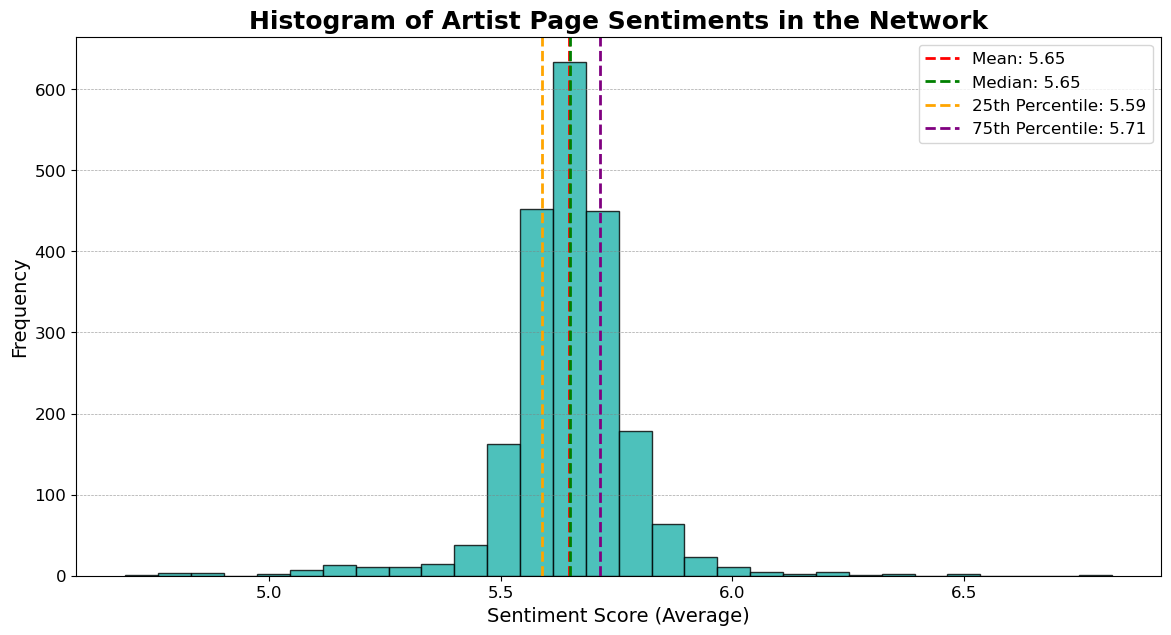

In [91]:

# Extract the 'average' sentiment attribute from all nodes in the graph
average_sentiments = [data['sentiment']['average'] for _, data in G.nodes(data=True) if 'sentiment' in data and data['sentiment']]

# Calculate statistics
mean_value = np.mean(average_sentiments)
median_value = np.median(average_sentiments)
variance_value = np.var(average_sentiments)
percentile_25 = np.percentile(average_sentiments, 25)
percentile_75 = np.percentile(average_sentiments, 75)

# Create a histogram with improved aesthetics
plt.figure(figsize=(14, 7))
plt.hist(average_sentiments, bins=30, color='lightseagreen', edgecolor='black', alpha=0.8)
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='--', linewidth=2, label=f'25th Percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='--', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')

# Add title and labels with improved font size and style
plt.title('Histogram of Artist Page Sentiments in the Network', fontsize=18, fontweight='bold')
plt.xlabel('Sentiment Score (Average)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize legend
plt.legend(fontsize=12)

# Add a grid for better readability
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Enhance tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


In [92]:

# Find the 10 nodes with the lowest 'average' sentiment scores
saddest_nodes = sorted(
    [(node, data['sentiment']['average']) for node, data in G.nodes(data=True) if 'sentiment' in data and data['sentiment']],
    key=lambda x: x[1]
)[:10]

# Find the 10 nodes with the highest 'average' sentiment scores
happiest_nodes = sorted(
    [(node, data['sentiment']['average']) for node, data in G.nodes(data=True) if 'sentiment' in data and data['sentiment']],
    key=lambda x: x[1],
    reverse=True
)[:10]

# Create DataFrames to display the results
saddest_nodes_df = pd.DataFrame(saddest_nodes, columns=['Node', 'Average Sentiment'])
happiest_nodes_df = pd.DataFrame(happiest_nodes, columns=['Node', 'Average Sentiment'])

# Print the DataFrames
print("Top 10 Saddest Nodes:")
print(saddest_nodes_df)

print("\nTop 10 Happiest Nodes:")
print(happiest_nodes_df)


Top 10 Saddest Nodes:
                            Node  Average Sentiment
0      Cole Deggs & The Lonesome              4.690
1                   Mats Radberg              4.775
2                The Highwaymen               4.780
3                    The Shires               4.780
4                 Bill Anderson               4.864
5                    Truck Stop               4.876
6                         Rehab               4.885
7                     McClymonts              4.980
8             Jolie & The Wanted              5.012
9  Jason Boland & the Stragglers              5.050

Top 10 Happiest Nodes:
                   Node  Average Sentiment
0         Shana Petrone           6.820000
1  Great Speckled Bird            6.500000
2         Herb Jeffreys           6.490000
3            Home Free            6.351456
4      Brandon Jenkins            6.324000
5          Brett Young            6.304737
6       Brent Anderson            6.240000
7          Jeff Knight            6.18

In [93]:
#remove the node that not in geners
with open('genres.txt', 'r') as f:
    genres_data = json.load(f)

# Get the singer names from the keys of the JSON object
singer_names_genres = [key for key in genres_data.keys()]

# Remove nodes from the graph that are not in the singer names from 'genres.txt'
nodes = list(G.nodes())
for node in nodes:
    if node not in singer_names_genres:
        G.remove_node(node)
# create a graph for Louvain community detection
G_Lou = G

# apply Louvain-algorithm
partition = community.best_partition(G_Lou)

In [ ]:
# Count the number of nodes in each community
community_counts = Counter(partition.values())

# Find the top 10 largest communities by node count
top_communities = [comm for comm, _ in community_counts.most_common(10)]

# Create a dictionary to map community IDs to their top 3 most connected nodes
community_representatives = {}

for comm_id in top_communities:
    # Filter nodes belonging to the current community
    nodes_in_community = [node for node, comm in partition.items() if comm == comm_id]
    # Sort nodes by their degree (number of connections)
    top_nodes = sorted(nodes_in_community, key=lambda n: G_Lou.degree(n), reverse=True)[:3]
    # Use these top 3 nodes as the representative names for the community
    community_representatives[comm_id] = top_nodes

# Modify the partition dictionary to include community labels
for node, comm_id in list(partition.items()):
    if comm_id in community_representatives:
        partition[node] = (community_representatives[comm_id])  # Tuple format: (community_id, representative_nodes)

In [110]:
community_counts

Counter({1: 478,
         3: 332,
         0: 325,
         4: 312,
         5: 121,
         7: 15,
         9: 6,
         6: 1,
         8: 1,
         10: 1,
         12: 1,
         13: 1,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         2: 1,
         11: 1})

In [107]:
# Initialize community sentiment dictionary using tuples as keys and skipping integers
community_sentiment = {
    tuple(com): [] for com in partition.values() if isinstance(com, list)
}

# Calculate sentiment for each node and add it to the respective community's list
for node, com in partition.items():
    # Only process if `com` is a list (converted to a tuple as the key)
    if isinstance(com, list):
        com_key = tuple(com)
        
        file_path = os.path.join(folder_path, node + ".txt")  # Add .txt extension
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                tokens = word_tokenize(content)
                sentiment = calculate_sentiment(tokens)
                if sentiment:
                    community_sentiment[com_key].append(sentiment)

In [108]:
# Calculate the average sentiment for each community
average_community_sentiment = {
    com: np.mean([s['average'] for s in sentiments]) if sentiments else 0
    for com, sentiments in community_sentiment.items()
}

# Find the 3 happiest and 3 saddest communities based on average sentiment
sorted_communities = sorted(average_community_sentiment.items(), key=lambda x: x[1], reverse=True)
happiest_communities = sorted_communities[:3]
saddest_communities = sorted_communities[-3:]
print(f"saddest_communities: {saddest_communities}")
print(f"happiest_communities: {happiest_communities}")

saddest_communities: [(('Marty Stuart', 'Ricky Skaggs', 'Old Crow Medicine Show'), 5.635533768166769), (('Willie Nelson', 'Johnny Cash', 'George Jones'), 5.601899551909774), (("Fiddlin' John Carson", 'Vernon Dalhart', 'Carson Robison'), 5.573009650004927)]
happiest_communities: [(('Beccy Cole', 'Troy Cassar-Daley', 'Amber Lawrence'), 5.821462748651679), (('Carrie Elkin',), 5.76596463022508), (('Aaron Benward',), 5.726565096952909)]


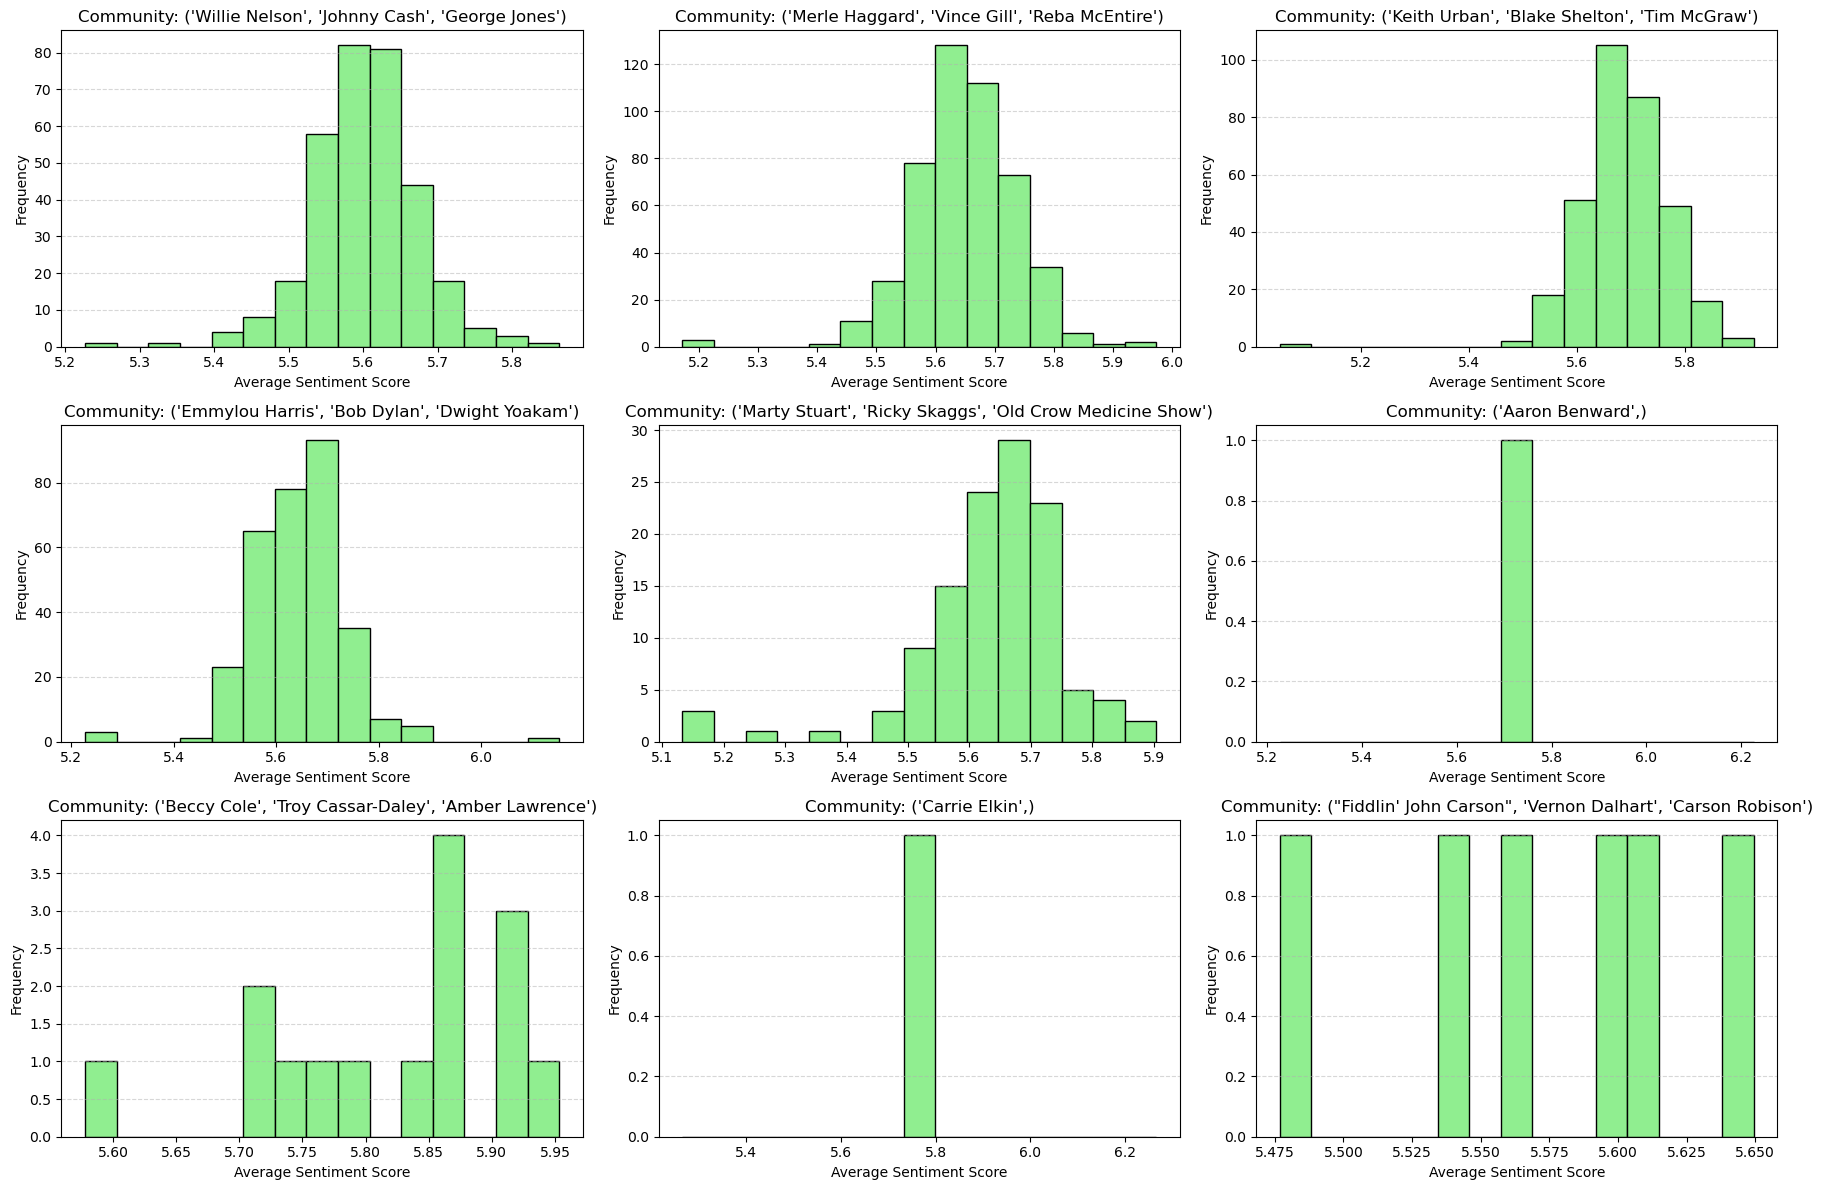

In [109]:
def plot_subplots(community_sentiment):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # Flatten the 3x3 array to iterate over

    # Filter communities that have sentiment data
    communities_with_sentiments = [(com, sentiments) for com, sentiments in community_sentiment.items() if sentiments]
    
    for i, (com, sentiments) in enumerate(communities_with_sentiments[:9]):  # Only plot up to 9 communities
        average_scores = [s['average'] for s in sentiments if 'average' in s]
        axes[i].hist(average_scores, bins=15, color='lightgreen', edgecolor='black')
        axes[i].set_title(f'Community: {com}')
        axes[i].set_xlabel('Average Sentiment Score')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Hide any unused subplots
    for j in range(len(communities_with_sentiments), 9):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example call to plot 3x3 subplots for the community sentiment histograms
plot_subplots(community_sentiment)